<a href="https://colab.research.google.com/github/Hemasri-data/Predicting-Recidivism-through-survival-models/blob/main/BAYESIAN_GAMMA_SURVIVAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymc numpyro arviz matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 6.5 MB/s eta 0:00:00


Shape of duration: (18316,)
Shape of event: (18316,)
Shape of age: (18316,)
Shape of priors_count: (18316,)


Output()

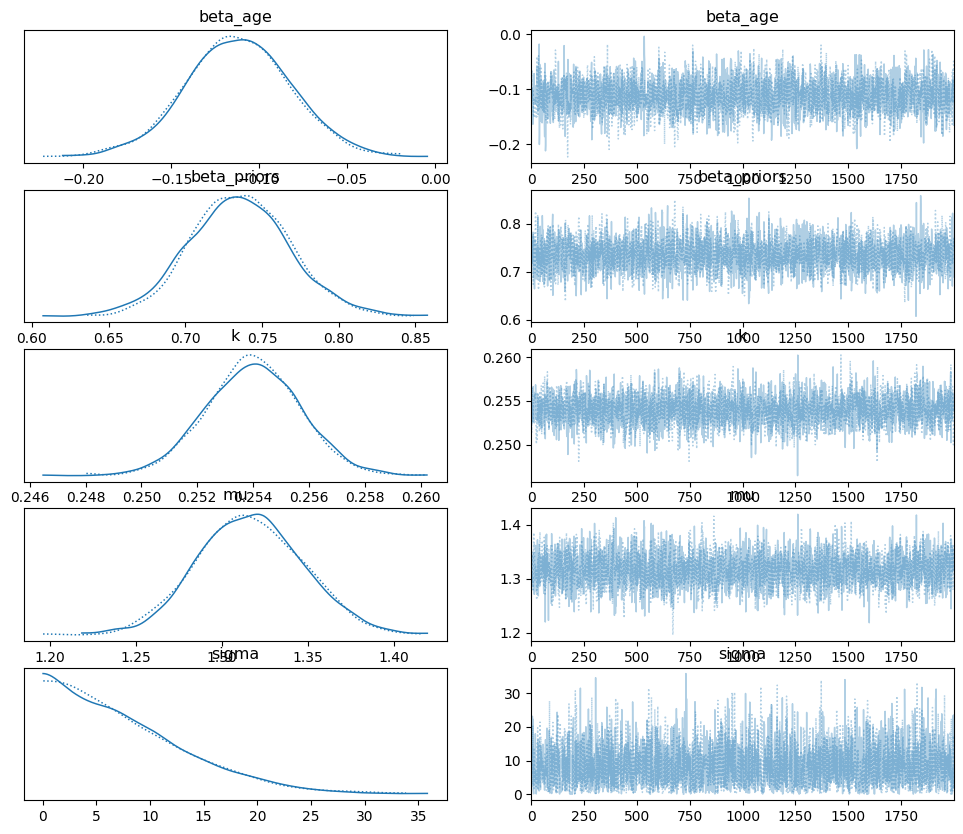

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_age    -0.112  0.030  -0.168   -0.055      0.001    0.000    3051.0   
beta_priors  0.735  0.032   0.677    0.801      0.001    0.000    3232.0   
k            0.254  0.002   0.251    0.257      0.000    0.000    2874.0   
mu           1.317  0.031   1.261    1.375      0.001    0.000    3173.0   
sigma        7.927  6.195   0.003   19.233      0.103    0.073    2294.0   

             ess_tail  r_hat  
beta_age       2026.0    1.0  
beta_priors    2556.0    1.0  
k              2801.0    1.0  
mu             2678.0    1.0  
sigma          1511.0    1.0  


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

# Load dataset
file_path = "//content/FINAL FILE.csv"
df = pd.read_csv(file_path)

# Drop rows with missing values in duration, event, and covariates
df = df.dropna(subset=["duration", "event", "age", "priors_count"])  # Ensures all arrays have the same shape

# Select relevant columns
duration = df["duration"].values
duration = duration + 1e-8
# Time-to-event
event = df["event"].values        # 1 = event occurred, 0 = censored
age = df["age"].values             # Example covariate
priors_count = df["priors_count"].values  # Example covariate

# Standardize covariates for better inference
age = (age - np.mean(age)) / np.std(age)
priors_count = (priors_count - np.mean(priors_count)) / np.std(priors_count)

# Debugging: Print Shapes
print(f"Shape of duration: {duration.shape}")
print(f"Shape of event: {event.shape}")
print(f"Shape of age: {age.shape}")
print(f"Shape of priors_count: {priors_count.shape}")

# Bayesian Generalized Gamma Model
with pm.Model() as model:

    # Hyperpriors for the Generalized Gamma distribution parameters
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    beta_age = pm.Normal("beta_age", mu=0, sigma=10)
    beta_priors = pm.Normal("beta_priors", mu=0, sigma=10)
    k = pm.HalfNormal("k", sigma=1)  # Shape parameter

    # Linear predictor for survival time
    lambda_ = pm.math.exp(mu + beta_age * age + beta_priors * priors_count)

    # Generalized Gamma likelihood
    obs = pm.Weibull("obs", alpha=k, beta=lambda_, observed=duration)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.9,init="adapt_diag")

# Posterior analysis
az.plot_trace(trace)
plt.show()

# Print summary statistics
print(az.summary(trace))


Shape of duration: (15457,)
Shape of event: (15457,)
Shape of age: (15457,)
Shape of priors_count: (15457,)


Output()

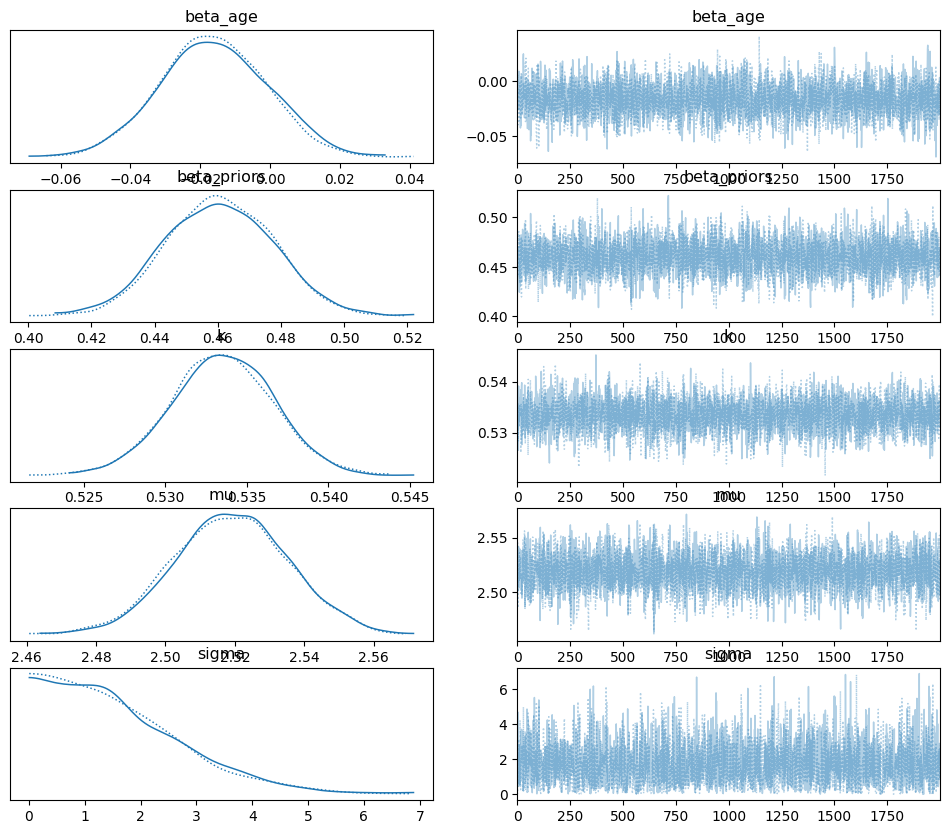

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_age    -0.016  0.015  -0.045    0.012       0.00    0.000    4039.0   
beta_priors  0.461  0.017   0.428    0.492       0.00    0.000    4067.0   
k            0.533  0.003   0.528    0.539       0.00    0.000    3841.0   
mu           2.519  0.017   2.491    2.553       0.00    0.000    4237.0   
sigma        1.616  1.196   0.001    3.768       0.02    0.014    2328.0   

             ess_tail  r_hat  
beta_age       2840.0    1.0  
beta_priors    2703.0    1.0  
k              2902.0    1.0  
mu             2652.0    1.0  
sigma          1495.0    1.0  


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/FINAL FILE.csv"
df = pd.read_csv(file_path)

# Drop rows with missing values in duration, event, and covariates
df = df.dropna(subset=["duration", "event", "age", "priors_count"])  # Ensures all arrays have the same shape

# Ensure duration > 0 to avoid Weibull issues
df = df[df["duration"] > 0]

# Select relevant columns
duration = df["duration"].values  # Time-to-event
event = df["event"].values        # 1 = event occurred, 0 = censored
age = df["age"].values             # Example covariate
priors_count = df["priors_count"].values  # Example covariate

# Standardize covariates for better inference
age = (age - np.mean(age)) / np.std(age)
priors_count = (priors_count - np.mean(priors_count)) / np.std(priors_count)

# Debugging: Print Shapes
print(f"Shape of duration: {duration.shape}")
print(f"Shape of event: {event.shape}")
print(f"Shape of age: {age.shape}")
print(f"Shape of priors_count: {priors_count.shape}")

# Bayesian Generalized Gamma Model
with pm.Model() as model:

    # More informative priors to avoid numerical instability
    mu = pm.Normal("mu", mu=0, sigma=2)
    sigma = pm.HalfNormal("sigma", sigma=2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=2)
    beta_priors = pm.Normal("beta_priors", mu=0, sigma=2)
    k = pm.HalfNormal("k", sigma=2)  # Shape parameter

    # Linear predictor for survival time
    lambda_ = pm.math.exp(mu + beta_age * age + beta_priors * priors_count)

    # Generalized Gamma likelihood
    obs = pm.Weibull("obs", alpha=k + 1e-6, beta=lambda_, observed=duration)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.9)

# Posterior analysis
az.plot_trace(trace)
plt.show()

# Print summary statistics
print(az.summary(trace))
